# Imports

In [1]:
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.stats import variation
from scipy import signal
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from itertools import accumulate

# Gillespies Algorithm

In [2]:
def run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None):
                
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
# Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for next event time if event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series

# SIR Model

In [3]:
# Define the deterministic SIR model
def SIR_model(y, t, beta, gamma, mu, N):
    S, I, R = y
    dSdt = mu * N - beta * S * I / N - mu * S
    dIdt = beta * S * I / N - mu * I - gamma * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

In [ ]:
# Example usage of the function
beta = 5
gamma = 1
mu = 0.1
N = 1000
infected_init = 49
recovered_init = 1
max_time = 60
random_seed = 42

# Unpack the results
time_series, X_series, Y_series, Z_series =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed)
#Plot
plt.figure(figsize=(10, 6))
plt.plot(time_series, X_series, label='Susceptible (X)')
plt.plot(time_series, Y_series, label='Infectious (Y)')
plt.plot(time_series, Z_series, label='Recovered (Z)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Gullispie: SIR Model Simulation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# First Experiment - Changing Seeding

In [ ]:
# Run the simulation with different random seeds
random_seeds = [42, 123, 987, 456, 789, 12, 24, 1002, 25, 20002, 102, 1243, 433, 532, 55]  # You can change these values
simulation_results = []

In [ ]:
for seed in random_seeds:
    time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)
    simulation_results.append((time_series, X_series, Y_series, Z_series))

# Create subplots for infected, susceptible, and recovered
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot the results for different random seeds
for i, seed in enumerate(random_seeds):
    axes[0].plot(simulation_results[i][0], simulation_results[i][1], label=f'Susceptible (Seed {seed})')
    axes[1].plot(simulation_results[i][0], simulation_results[i][2], label=f'Infectious (Seed {seed})')
    axes[2].plot(simulation_results[i][0], simulation_results[i][3], label=f'Recovered (Seed {seed})')

# Set titles and labels for each subplot
axes[0].set_title('Susceptible Population')
axes[0].set_ylabel('Population')
axes[0].legend()

axes[1].set_title('Infectious Population')
axes[1].set_ylabel('Population')
axes[1].legend()

axes[2].set_title('Recovered Population')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Population')
axes[2].legend()

plt.tight_layout()
plt.show()

# Variability

In [ ]:
# Define parameters
beta_values = [0.4, 0.6, .8]  # Example beta values
gamma = 0.05
mu = 1/70
N = 500
infected_init = 5
S0 = N - infected_init
recovered_init = 0
t = np.linspace(0, 500, 10000)

# Storage for results
mean_stochastic_I = []

# Loop over beta values
for beta in beta_values:
    # Generate stochastic realizations
    num_simulations = 20
    stochastic_I_realizations = []

    for _ in range(num_simulations):
        # Initialize compartments
        X = N - infected_init - recovered_init
        Y = infected_init
        Z = recovered_init

        # Initialize lists to store population values
        X_values = [X]
        Y_values = [Y]
        Z_values = [Z]

        # Time increment
        dt = t[1] - t[0]

        for _ in range(1, len(t)):
            # Calculate rates
            rates = [
                mu * N,                           # Birth rate
                beta * X * Y / N,                 # Infection rate
                gamma * Y,                        # Recovery rate
                mu * X,                           # Death rate for susceptible
                mu * Y,                           # Death rate for infected
                mu * Z                            # Death rate for recovered
            ]

            # Calculate total rate
            total_rate = sum(rates)

            # Calculate time until the next event
            time_until_event = np.random.exponential(1 / total_rate)

            # Choose the event that happens next
            event = np.random.choice(6, p=[rates[i] / total_rate for i in range(6)])

            # Update compartments based on the chosen event
            if event == 0:
                X += 1
            elif event == 1:
                X -= 1
                Y += 1
            elif event == 2:
                Y -= 1
                Z += 1
            elif event == 3:
                X -= 1
            elif event == 4:
                Y -= 1
            else:
                Z -= 1

            # Append the updated values to the lists
            X_values.append(X)
            Y_values.append(Y)
            Z_values.append(Z)

        # Append the results of a single stochastic realization to the list
        stochastic_I_realizations.append(Y_values)

    # Calculate the mean of stochastic realizations
    mean_I = np.mean(stochastic_I_realizations, axis=0)
    mean_stochastic_I.append(mean_I)

    # Integrate the deterministic SIR model for comparison
    sol = odeint(SIR_model, [S0, infected_init, recovered_init], t, args=(beta, gamma, mu, N))
    deterministic_I = sol[:, 1]

    # Plot individual stochastic realizations, the mean, and deterministic SIR model
    plt.figure(figsize=(10, 6))
#     for i in range(num_simulations):
#         plt.plot(t, stochastic_I_realizations[i], label=f'Stochastic Realization {i + 1}', alpha=0.5)
    plt.plot(t, mean_I, label=f'Stochastic Mean (Beta = {beta})', linestyle='-', linewidth=2)
    plt.plot(t, deterministic_I, label=f'Deterministic (Beta = {beta})', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Infectious (I)')
    plt.title(f'Stochastic vs. Deterministic SIR Model (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()


# Covariance:

In [ ]:
## Function to calculate covariance between S and I
def calculate_covariance(S_series, I_series):
    return np.cov(S_series, I_series)[0, 1]

# Define parameter ranges to explore
beta_values = [0.2, 0.5]  # Example beta values
gamma = 0.5 # Fixed gamma value
mu = 1/70 # Fixed mu value

# Define initial infected values to explore
initial_infected_values = [1, 3]  # Example initial infected values

# Other simulation settings
N = 100
recovered_init = 1
max_time = 300
num_simulations = 20  # Number of stochastic simulations for each parameter combination

# Storage for results
parameter_settings = []

mean_infectious_populations = []
variances = []
covariances = []

# Loop over initial infected values
for infected_init in initial_infected_values:
    # Loop over beta values
    for beta in beta_values:
        # Store current parameter combination
        parameter_settings.append({"beta": beta, "gamma": gamma, "mu": mu, "infected_init": infected_init})

        # Arrays to store simulation results
        infectious_populations = np.zeros((num_simulations, max_time))
        susceptible_populations = np.zeros((num_simulations, max_time))

        # Run multiple simulations for the current parameter combination
        for i in range(num_simulations):
            time_series, X_series, Y_series, Z_series = run_sir_simulation(
                beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=i
            )

            # Truncate the series to match max_time
            time_series = time_series[:max_time]
            X_series = X_series[:max_time]
            Y_series = Y_series[:max_time]
            Z_series = Z_series[:max_time]

            # Store infectious and susceptible populations over time
            infectious_populations[i, :len(Y_series)] = Y_series
            susceptible_populations[i, :len(X_series)] = X_series

        # Calculate statistics for the current parameter combination
        mean_infectious = np.mean(infectious_populations, axis=0)
        var_infectious = np.var(infectious_populations, axis=0)
        covariance_si = calculate_covariance(susceptible_populations, infectious_populations)

        # Store results
        mean_infectious_populations.append(mean_infectious)
        variances.append(var_infectious)
        covariances.append(covariance_si)

# Visualization
plt.figure(figsize=(15, 5))

# Plot covariances between susceptible and infectious populations for different initial infected and beta values
plt.subplot(1, 3, 3)
for i, infected_init in enumerate(initial_infected_values):
    for j, beta in enumerate(beta_values):
        label = f'Initial Infected = {infected_init}, Beta = {beta}'
        plt.plot(range(max_time), [covariances[i * len(beta_values) + j]] * max_time, label=label)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Covariance between S and I vs. Time (Initial Infected and Beta Variations)')
plt.legend()

plt.tight_layout()
plt.show()


# Stochastic Resonance

- vary N, beta 

In [20]:
# Define parameters for the stochastic SIR model
beta_values = [0.1, 5]  # Vary the transmission rate (beta)
N_values = [200, 10000]  # Vary the total population size

# Other parameters for both models
gamma = 0.05
mu = 1/70
infected_init = 5
recovered_init = 0
max_time = 1000
# random_seed = 23

# Initialize lists to store results
stochastic_results = []
deterministic_results = []

# Loop over beta and N combinations
for beta in beta_values:
    for N in N_values:
        # Run simulations for the stochastic SIR model
        time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time)

        stochastic_results.append((beta, N, time_series, X_series, Y_series, Z_series))  # Store results for plotting

        # Time points for the deterministic model
        t_deterministic = np.linspace(0, max_time, len(time_series))

        # Initial conditions for the deterministic model
        S0_deterministic = N - infected_init
        I0_deterministic = infected_init
        R0_deterministic = 0
        y0_deterministic = [S0_deterministic, I0_deterministic, R0_deterministic]

        # Solve the deterministic SIR model
        sol_deterministic = odeint(SIR_model, y0_deterministic, t_deterministic, args=(beta, gamma, mu, N))
        S_deterministic, I_deterministic, R_deterministic = sol_deterministic[:, 0], sol_deterministic[:, 1], sol_deterministic[:, 2]

        deterministic_results.append((beta, N, t_deterministic, S_deterministic, I_deterministic, R_deterministic))  # Store results for plotting

# Loop over beta and N combinations
for beta, N, time_series, X_series, Y_series, Z_series in stochastic_results:
    plt.figure(figsize=(12, 6))
    plt.rc('font', size=14) 
    plt.plot(time_series, X_series, label=f'Stochastic Susceptible (N={N}, beta={beta})', linestyle='--', alpha=0.7)
    plt.plot(time_series, Y_series, label=f'Stochastic Infected (N={N}, beta={beta})', linestyle='--', alpha=0.7)
    plt.plot(time_series, Z_series, label=f'Stochastic Recovered (N={N}, beta={beta})', linestyle='--', alpha=0.7)

    # Find the corresponding deterministic result for this beta and N
    deterministic_result = next(result for result in deterministic_results if result[0] == beta and result[1] == N)
    t_deterministic, S_deterministic, I_deterministic, R_deterministic = deterministic_result[2], deterministic_result[3], deterministic_result[4], deterministic_result[5]
    plt.plot(t_deterministic, S_deterministic, label=f'Deterministic Susceptible (N={N}, beta={beta})', linestyle='-')
    plt.plot(t_deterministic, I_deterministic, label=f'Deterministic Infected (N={N}, beta={beta})', linestyle='-')
    plt.plot(t_deterministic, R_deterministic, label=f'Deterministic Recovered (N={N}, beta={beta})', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f' Examine Stochastic Resonance vs. Deterministic SIR Model \n N={N}, β={beta}, γ={gamma}, μ=1/70')
    plt.legend()
    plt.grid(True)

    # Save the graph to a file
    plt.savefig(f'sir_resonance_N{N}_beta{beta}.png')  
    plt.clf()  


<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [15]:
# Define parameters
beta_values = [0.2, 5]
N_values = [200, 10000]
gamma = 0.05
mu = 1/70
infected_init = 5
recovered_init = 0
max_time = 1000

equilibrium_points = []

# Loop over beta and N combinations
for beta in beta_values:
    for N in N_values:
        # Time points
        t = np.linspace(0, max_time, max_time + 1)

        # Initial conditions
        S0 = N - infected_init
        I0 = infected_init
        R0 = recovered_init
        y0 = [S0, I0, R0]

        # Solve the deterministic SIR model
        sol = odeint(SIR_model, y0, t, args=(beta, gamma, mu, N))
        
        # Get the equilibrium point at the end of the simulation
        S_eq, I_eq, R_eq = sol[-1]
        
        equilibrium_points.append((beta, N, S_eq, I_eq, R_eq))

# Print equilibrium points
for beta, N, S_eq, I_eq, R_eq in equilibrium_points:
    print(f"Equilibrium values for Beta={beta}, N={N}:")
    print(f"Susceptible (S): {S_eq}")
    print(f"Infected (I): {I_eq}")
    print(f"Recovered (R): {R_eq}")
    print("-" * 30)

Equilibrium values for Beta=0.2, N=200:
Susceptible (S): 64.2857144274264
Infected (I): 30.158730113685216
Recovered (R): 105.55555545888838
------------------------------
Equilibrium values for Beta=0.2, N=10000:
Susceptible (S): 3214.285717719513
Infected (I): 1507.9365027979604
Recovered (R): 5277.777779482527
------------------------------
Equilibrium values for Beta=5, N=200:
Susceptible (S): 2.5714285714292977
Infected (I): 43.87301587300408
Recovered (R): 153.55555555556663
------------------------------
Equilibrium values for Beta=5, N=10000:
Susceptible (S): 128.57142853535342
Infected (I): 2193.650794236398
Recovered (R): 7677.777777228249
------------------------------


# Increased Transients
- run it for multiple simulations and take the average. 

In [4]:
def run_sir_simulation_phase(beta, gamma, mu, N, infected_init, recovered_init, max_time=365):

    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for the next event time if the event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    # Lists to store the values for creating a phase-space diagram
    X_values = []
    Y_values = []
    Z_values = []

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])

        # Store values for the phase-space diagram
        X_values.append(X)
        Y_values.append(Y)
        Z_values.append(Z)

        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose the event to execute according to the minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, X_values, Y_values, Z_values


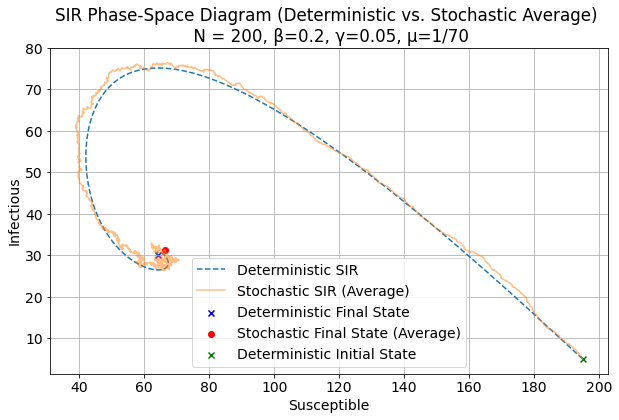

In [12]:
# Parameters for the deterministic/Stochastic SIR model
beta = 0.2
gamma = 0.05  # Recovery rate
mu = 1/70  # Birth/death rate
N = 200  # Total population
infected_init = 5
recovered_init = 0
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645]

# Initialize a list to store the results of multiple simulations
stochastic_results = []

# Number of simulations
num_simulations = len(random_seeds)

min_length = float('inf')  # Initialize with a large value

for seed in random_seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Run the stochastic SIR simulation
    _, _, _, _, X_values, Y_values, Z_values = run_sir_simulation_phase(
        beta, gamma, mu, N, infected_init, recovered_init, 365)

    # Append the results to the list
    stochastic_results.append((X_values, Y_values))

    # Determine the minimum length of the simulations
    min_length = min(min_length, len(X_values))

# Initialize arrays to store the average results
average_X_values = np.zeros(min_length)
average_Y_values = np.zeros(min_length)

# Calculate the average of the results
for X_values, Y_values in stochastic_results:
    average_X_values += np.array(X_values[:min_length])
    average_Y_values += np.array(Y_values[:min_length])

average_X_values /= num_simulations
average_Y_values /= num_simulations

# Initial conditions for the deterministic SIR model
initial_conditions = [N - infected_init - recovered_init, infected_init, recovered_init]

# Time points for the deterministic model
max_time = np.linspace(0, 365, min_length)

# Simulate the deterministic SIR model
solution_deterministic = odeint(SIR_model, initial_conditions, max_time, args=(beta, gamma, mu, N))
S, I, R = solution_deterministic.T

# Plot both the stochastic and deterministic SIR models on the same plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=14) 
plt.plot(S, I, label='Deterministic SIR', linestyle='--')
plt.plot(average_X_values, average_Y_values, label='Stochastic SIR (Average)', alpha=0.5)

# Mark the final states with scatter points
plt.scatter([S[-1]], [I[-1]], c='blue', marker='x', label='Deterministic Final State')
plt.scatter([average_X_values[-1]], [average_Y_values[-1]], c='red', marker='o', label='Stochastic Final State (Average)')

# Mark the initial states with scatter points
plt.scatter([S[0]], [I[0]], c='green', marker='x', label='Deterministic Initial State')

plt.xlabel('Susceptible')
plt.ylabel('Infectious')
plt.title(f'SIR Phase-Space Diagram (Deterministic vs. Stochastic Average) \n N = 200, β={beta}, γ={gamma}, μ=1/70')
plt.legend()
plt.grid(True)
plt.savefig('SIR_high_transients.png')  
plt.show()


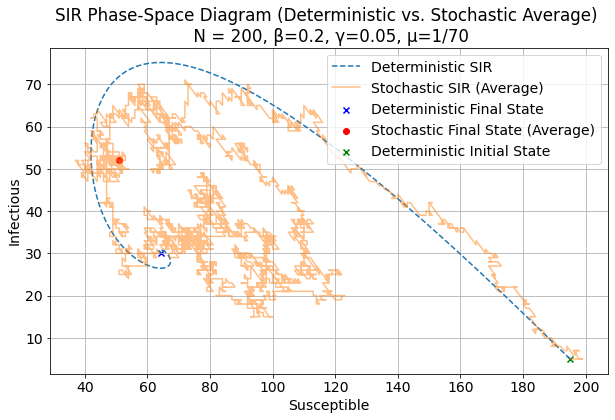

In [22]:
# Parameters for the deterministic/Stochastic SIR model
beta = 0.2
gamma = 0.05  # Recovery rate
mu = 1/70  # Birth/death rate
N = 200  # Total population
infected_init = 5
recovered_init = 0
random_seeds = [987]

# Initialize a list to store the results of multiple simulations
stochastic_results = []

# Number of simulations
num_simulations = len(random_seeds)

min_length = float('inf')  # Initialize with a large value

for seed in random_seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Run the stochastic SIR simulation
    _, _, _, _, X_values, Y_values, Z_values = run_sir_simulation_phase(
        beta, gamma, mu, N, infected_init, recovered_init, 365)

    # Append the results to the list
    stochastic_results.append((X_values, Y_values))

    # Determine the minimum length of the simulations
    min_length = min(min_length, len(X_values))

# Initialize arrays to store the average results
average_X_values = np.zeros(min_length)
average_Y_values = np.zeros(min_length)

# Calculate the average of the results
for X_values, Y_values in stochastic_results:
    average_X_values += np.array(X_values[:min_length])
    average_Y_values += np.array(Y_values[:min_length])

average_X_values /= num_simulations
average_Y_values /= num_simulations

# Initial conditions for the deterministic SIR model
initial_conditions = [N - infected_init - recovered_init, infected_init, recovered_init]

# Time points for the deterministic model
max_time = np.linspace(0, 365, min_length)

# Simulate the deterministic SIR model
solution_deterministic = odeint(SIR_model, initial_conditions, max_time, args=(beta, gamma, mu, N))
S, I, R = solution_deterministic.T

# Plot both the stochastic and deterministic SIR models on the same plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=14) 
plt.plot(S, I, label='Deterministic SIR', linestyle='--')
plt.plot(average_X_values, average_Y_values, label='Stochastic SIR (Average)', alpha=0.5)

# Mark the final states with scatter points
plt.scatter([S[-1]], [I[-1]], c='blue', marker='x', label='Deterministic Final State')
plt.scatter([average_X_values[-1]], [average_Y_values[-1]], c='red', marker='o', label='Stochastic Final State (Average)')

# Mark the initial states with scatter points
plt.scatter([S[0]], [I[0]], c='green', marker='x', label='Deterministic Initial State')

plt.xlabel('Susceptible')
plt.ylabel('Infectious')
plt.title(f'SIR Phase-Space Diagram (Deterministic vs. Stochastic Average) \n N = 200, β={beta}, γ={gamma}, μ=1/70')
plt.legend()
plt.grid(True)
plt.savefig('SIR_high_transients_one_seed.png')  
plt.show()


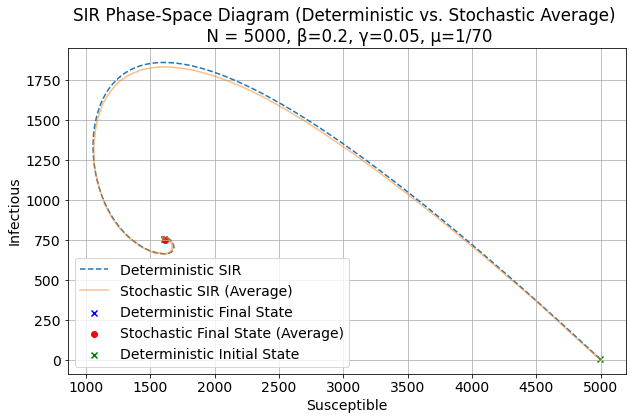

In [13]:
# Parameters for the deterministic/Stochastic SIR model
beta = 0.2
gamma = 0.05  # Recovery rate
mu = 1/70  # Birth/death rate
N = 5000  # Total population
infected_init = 5
recovered_init = 0
num_simulations = 10

min_length = float('inf')  # Initialize with a large value

# Initialize a list to store the results of multiple simulations
stochastic_results = []

# Random seeds
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371]

for seed in random_seeds:
    np.random.seed(seed)
    for _ in range(num_simulations):
        # Run the stochastic SIR simulation
        _, _, _, _, X_values, Y_values, Z_values = run_sir_simulation_phase(
            beta, gamma, mu, N, infected_init, recovered_init, 365)

        # Append the results to the list
        stochastic_results.append((X_values, Y_values))

        # Determine the minimum length of the simulations
        min_length = min(min_length, len(X_values))

# Initialize arrays to store the average results
average_X_values = np.zeros(min_length)
average_Y_values = np.zeros(min_length)

# Calculate the average of the results
for X_values, Y_values in stochastic_results:
    average_X_values += np.array(X_values[:min_length])
    average_Y_values += np.array(Y_values[:min_length])

average_X_values /= (num_simulations * len(random_seeds))
average_Y_values /= (num_simulations * len(random_seeds))

# Initial conditions for the deterministic SIR model
initial_conditions = [N - infected_init - recovered_init, infected_init, recovered_init]

# Time points for the deterministic model
max_time = np.linspace(0, 365, min_length)

# Simulate the deterministic SIR model
solution_deterministic = odeint(SIR_model, initial_conditions, max_time, args=(beta, gamma, mu, N))
S, I, R = solution_deterministic.T

# Plot both the stochastic and deterministic SIR models on the same plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=14)
plt.plot(S, I, label='Deterministic SIR', linestyle='--')
plt.plot(average_X_values, average_Y_values, label='Stochastic SIR (Average)', alpha=0.5)

# Mark the final states with scatter points
plt.scatter([S[-1]], [I[-1]], c='blue', marker='x', label='Deterministic Final State')
plt.scatter([average_X_values[-1]], [average_Y_values[-1]], c='red', marker='o', label='Stochastic Final State (Average)')

# Mark the initial states with scatter points
plt.scatter([S[0]], [I[0]], c='green', marker='x', label='Deterministic Initial State')
# plt.scatter([X_values[0]], [Y_values[0]], c='blue', marker='o', label='Stochastic Initial State')

plt.xlabel('Susceptible')
plt.ylabel('Infectious')
plt.title(f'SIR Phase-Space Diagram (Deterministic vs. Stochastic Average) \n N = 5000, β={beta}, γ={gamma}, μ=1/70')
plt.legend()
plt.grid(True)
plt.savefig('SIR_low_transients.png')  # You can change the format as needed
plt.show()

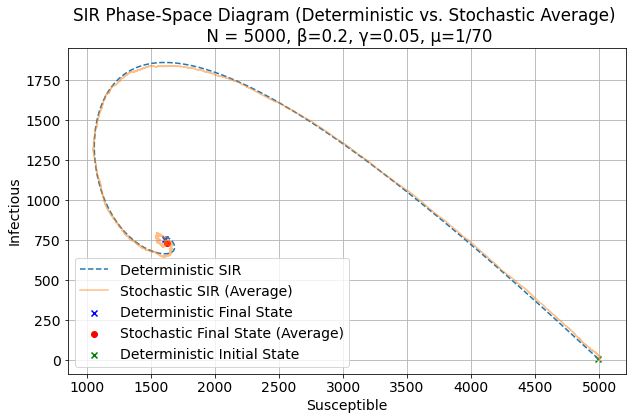

In [23]:
# Parameters for the deterministic/Stochastic SIR model
beta = 0.2
gamma = 0.05  # Recovery rate
mu = 1/70  # Birth/death rate
N = 5000  # Total population
infected_init = 5
recovered_init = 0
num_simulations = 10

min_length = float('inf')  # Initialize with a large value

# Initialize a list to store the results of multiple simulations
stochastic_results = []

# Random seeds
random_seeds = [987]

for seed in random_seeds:
    np.random.seed(seed)
    for _ in range(num_simulations):
        # Run the stochastic SIR simulation
        _, _, _, _, X_values, Y_values, Z_values = run_sir_simulation_phase(
            beta, gamma, mu, N, infected_init, recovered_init, 365)

        # Append the results to the list
        stochastic_results.append((X_values, Y_values))

        # Determine the minimum length of the simulations
        min_length = min(min_length, len(X_values))

# Initialize arrays to store the average results
average_X_values = np.zeros(min_length)
average_Y_values = np.zeros(min_length)

# Calculate the average of the results
for X_values, Y_values in stochastic_results:
    average_X_values += np.array(X_values[:min_length])
    average_Y_values += np.array(Y_values[:min_length])

average_X_values /= (num_simulations * len(random_seeds))
average_Y_values /= (num_simulations * len(random_seeds))

# Initial conditions for the deterministic SIR model
initial_conditions = [N - infected_init - recovered_init, infected_init, recovered_init]

# Time points for the deterministic model
max_time = np.linspace(0, 365, min_length)

# Simulate the deterministic SIR model
solution_deterministic = odeint(SIR_model, initial_conditions, max_time, args=(beta, gamma, mu, N))
S, I, R = solution_deterministic.T

# Plot both the stochastic and deterministic SIR models on the same plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=14)
plt.plot(S, I, label='Deterministic SIR', linestyle='--')
plt.plot(average_X_values, average_Y_values, label='Stochastic SIR (Average)', alpha=0.5)

# Mark the final states with scatter points
plt.scatter([S[-1]], [I[-1]], c='blue', marker='x', label='Deterministic Final State')
plt.scatter([average_X_values[-1]], [average_Y_values[-1]], c='red', marker='o', label='Stochastic Final State (Average)')

# Mark the initial states with scatter points
plt.scatter([S[0]], [I[0]], c='green', marker='x', label='Deterministic Initial State')
# plt.scatter([X_values[0]], [Y_values[0]], c='blue', marker='o', label='Stochastic Initial State')

plt.xlabel('Susceptible')
plt.ylabel('Infectious')
plt.title(f'SIR Phase-Space Diagram (Deterministic vs. Stochastic Average) \n N = 5000, β={beta}, γ={gamma}, μ=1/70')
plt.legend()
plt.grid(True)
plt.savefig('SIR_low_transients_one_seed.png')  # You can change the format as needed
plt.show()

# Extinction events 
- think about varying beta or N and just plot its effect on the infected curve.

In [ ]:
def run_sir_simulation_extinction(beta, gamma, mu, N, infected_init, recovered_init, max_time=60, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
        return delta_t

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0
    extinction = []  # Initialize the list to track extinction times
    extinct_compartment = None  # Initialize variable to store the extinct compartment

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        # Check for extinction
        if (X <= 0) or (Y <= 0) or (Z <= 0):
            extinction_time = time
            extinction.append(extinction_time)  # Track extinction time
            
            # Determine the extinct compartment
            if X <= 0:
                extinct_compartment = 'Susceptible (X)'
            elif Y <= 0:
                extinct_compartment = 'Infectious (Y)'
            else:
                extinct_compartment = 'Recovered (Z)'
            
            break

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Check if an extinction event occurred
#     if ext_timelist:
#         print(f"Extinction(s) occurred at time(s): {ext_timelist}")

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, extinction, extinct_compartment


In [ ]:
# Parameters
gamma = 0.5
mu = 1/70
N = 200
infected_init = 5
recovered_init = 1
max_time = 365
n_simulations = 100  # Number of simulations per beta value

# Varying values of beta
beta_values = [1, 4, 6, 8, 10]
# Loop over different beta values
for beta in beta_values:
    print(f"Running simulations for beta = {beta}")
    extinction_info_all = []  # List to store extinction info for multiple simulations

    for _ in range(n_simulations):
        # Reset the extinction info list for each simulation
        extinction_info = {}

        time_series, X_series, Y_series, Z_series, extinction_times, extinct_compartment = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None
        )

        # Append the information for this simulation to the list
        extinction_info["Beta"] = beta
        extinction_info["Extinction Times"] = ", ".join(map(str, extinction_times))
        extinction_info["Extinct Compartment"] = extinct_compartment

        extinction_info_all.append(extinction_info)

        # Example: Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(time_series, X_series, label='Susceptible (X)')
        plt.plot(time_series, Y_series, label='Infectious (Y)')
        plt.plot(time_series, Z_series, label='Recovered (Z)')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title(f'Gullispie: SIR Model Simulation (Beta = {beta})')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print extinction information for all simulations
    for simulation_info in extinction_info_all:
        print(f"Beta: {simulation_info['Beta']}, Extinction Times: {simulation_info['Extinction Times']}, Extinct Compartment: {simulation_info['Extinct Compartment']}")

In [ ]:
# Parameters
gamma = 0.5
mu = 1/70
N = 200
infected_init = 5
recovered_init = 1
max_time = 365
n_simulations = 100  # Number of simulations per beta value

# Varying values of beta
beta_values = [1, 4, 6, 8, 10]
average_extinction_times = []

# Loop over different beta values
for beta in beta_values:
    print(f"Running simulations for beta = {beta}")
    extinction_times_all = []  # List to store extinction times for multiple simulations

    for _ in range(n_simulations):
        # Reset the extinction times list for each simulation
        extinction_times = []

        _, _, _, _, extinction_times, _ = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None
        )

        # Append the list of extinction times for this simulation to the master list
        extinction_times_all.append(extinction_times)

    # Calculate the average of extinction times for this beta
    average_extinction_time = np.mean(extinction_times_all)
    average_extinction_times.append(average_extinction_time)

# Plot the average extinction times
plt.figure(figsize=(10, 6))
plt.plot(beta_values, average_extinction_times, marker='o')
plt.xlabel('Beta (Infection Rate)')
plt.ylabel('Average Extinction Time (Days)')
plt.title('Average Extinction Times vs. Beta')
plt.grid(True)
plt.show()

In [ ]:
# Parameters
gamma = 0.5
mu = 1/70
infected_init = 5
recovered_init = 1
max_time = 365
n_simulations = 20  # Number of simulations per N value
beta = 4

# Varying values of N
N_values = [100, 500, 1000, 10000]

# Loop over different N values
for N in N_values:
    print(f"Running simulations for N = {N}")
    extinction_info_all = []  # List to store extinction info for multiple simulations

    for _ in range(n_simulations):
        # Reset the extinction info list for each simulation
        extinction_info = {}

        time_series, X_series, Y_series, Z_series, extinction_times, extinct_compartment = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None
        )

        # Append the information for this simulation to the list
        extinction_info["N"] = N
        extinction_info["Extinction Times"] = ", ".join(map(str, extinction_times))
        extinction_info["Extinct Compartment"] = extinct_compartment

        extinction_info_all.append(extinction_info)

        # Example: Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(time_series, X_series, label='Susceptible (X)')
        plt.plot(time_series, Y_series, label='Infectious (Y)')
        plt.plot(time_series, Z_series, label='Recovered (Z)')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title(f'Gullispie: SIR Model Simulation (N = {N})')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print extinction information for all simulations
    for simulation_info in extinction_info_all:
        print(f"N: {simulation_info['N']}, Extinction Times: {simulation_info['Extinction Times']}, Extinct Compartment: {simulation_info['Extinct Compartment']}")

In [ ]:
# Parameters
gamma = 0.5
mu = 1/70
infected_init = 5
recovered_init = 1
max_time = 365
n_simulations = 10  # Number of simulations per N value
beta = 4

# Varying values of N
N_values = [100, 500, 1000, 10000]

average_extinction_times = []  # List to store average extinction times for each N

# Loop over different N values
for N in N_values:
    print(f"Running simulations for N = {N}")
    extinction_times_all = []  # List to store extinction times for multiple simulations

    for _ in range(n_simulations):
        time_series, X_series, Y_series, Z_series, extinction_times, extinct_compartment = run_sir_simulation_extinction(
            beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=None
        )

        # Append the extinction times for this simulation to the list
        extinction_times_all.extend(extinction_times)

    # Calculate the average extinction time for this N
    average_extinction_time = np.mean(extinction_times_all)
    average_extinction_times.append(average_extinction_time)

# Plot the average extinction times as a function of N
plt.figure(figsize=(10, 6))
plt.plot(N_values, average_extinction_times, marker='o', linestyle='-', color='b')
plt.xlabel('N (Total Population)')
plt.ylabel('Average Extinction Time (Days)')
plt.title('Average Extinction Time vs. N')
plt.grid(True)
plt.show()

# Print average extinction times
for N, avg_ext_time in zip(N_values, average_extinction_times):
    print(f"N: {N}, Average Extinction Time: {avg_ext_time}")

# Critical Community Size